# 01: Classification

> Explainable AI for liquefaction

**Exercise:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/01-classification/01-classification-exercise.ipynb)
**Solution:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/01-classification/01-classification.ipynb)

### Install packages

In [1]:
!pip3 install scikit-learn pandas --quiet
!pip3 install xgboost --quiet
!pip3 install shap --quiet

## Liquefaction

> Durante, M. G., & Rathje, E. M. (2021). An exploration of the use of machine learning to predict lateral spreading. Earthquake Spectra, 37(4), 2288-2314.

Soil liquefaction is a phenomenon that typically occurs in saturated loose sandy soils subjected to rapid loading conditions, such as earthquakes. The generation of excess pore water pressure is a direct consequence of the rapid loading, which can lead to a sudden reduction in the strength and stiffness of the soil. In the presence of gently sloping ground or near the free face of a slope, the occurrence of earthquake-induced liquefaction may generate lateral displacements, known as lateral spreading.

![liquefaction](liquefaction.png)

> Fig: (a) Observed liquefaction-related damage (data from NZGD, 2013), and (b) lateral spreading
horizontal displacement observed from optical image correlation (data from Rathje et al., 2017b) in the
Avon River area for the 2011 Christchurch earthquake

## Lateral spreading classification

Durante and Rathje (2021) classified sites that experienced more than 0.3 m displacement as lateral spreading. We now evaluate different factors that influence soil lateral spreading, such as (i) Ground Water Table (ground water closer to surface means more chance of liquefaction), (ii) slope angle (steeper the slope more lateral spreading), (iii) PGA - Peak Ground acceleration (intensity of earthquake shaking), and (iv) elevation (certain sites on high terrace don't show lateral spreading).

![Factors affecting liquefaction](liq-factors.png)

> Image credits: Durante and Rathje (2021).

### Explore data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/kks32-courses/sciml/main/lectures/01-classification/RF_YN_Model3.csv')

In [4]:
df.head()

,Test ID,GWD (m),Elevation,L (km),Slope (%),PGA (g),Target
0,182,0.370809,0.909116,0.319117,5.465739,0.546270,0
1,15635,1.300896,1.123009,0.211770,0.905948,0.532398,0
2,8292,1.300896,0.847858,0.195947,0.849104,0.532398,0
3,15629,1.788212,2.044325,0.115795,0.451034,0.542307,0
4,183,1.637517,2.003797,0.137265,0.941866,0.545784,1


### Filtering for features

Remove any feature in the dataset that we don't want to include in the training process.

In [5]:
df = df.drop(['Test ID', 'Elevation'], axis=1)
df.head()

,GWD (m),L (km),Slope (%),PGA (g),Target
0,0.370809,0.319117,5.465739,0.546270,0
1,1.300896,0.211770,0.905948,0.532398,0
2,1.300896,0.195947,0.849104,0.532398,0
3,1.788212,0.115795,0.451034,0.542307,0
4,1.637517,0.137265,0.941866,0.545784,1


In [6]:
X = df.copy(deep=True)
y = df['Target']
y.head()

0    0
1    0
2    0
3    0
4    1
Name: Target, dtype: int64

### Training, testing and validation

When developing a machine learning model, it is common practice to divide the available data into three subsets - training, validation, and testing. This is done to properly assess model performance and generalizability.

The training set is used to fit the parameters of the model. The majority of the data, typically 60-80%, is allocated for training so that the model can learn the underlying patterns.

The validation set is used to tune any hyperparameters of the model and make architectural choices. For example, it helps decide the number of hidden layers and units in a neural network. Typically 20% of data is used for validation.

The test set provides an unbiased evaluation of the fully-trained model's performance. It is critical for getting an accurate estimate of how the model will work on new unseen data. Usually 20% of the data is reserved for testing.

The splits should be made randomly while ensuring the class distribution is approximately balanced across all sets. No data from the validation or test sets should be used during training. This prevents overfitting and ensures the evaluation reflects real-world performance.

In [7]:
X

,GWD (m),L (km),Slope (%),PGA (g),Target
0,0.370809,0.319117,5.465739,0.546270,0
1,1.300896,0.211770,0.905948,0.532398,0
2,1.300896,0.195947,0.849104,0.532398,0
3,1.788212,0.115795,0.451034,0.542307,0
4,1.637517,0.137265,0.941866,0.545784,1
...,...,...,...,...,...
7286,1.631807,0.352863,0.839925,0.420179,0
7287,1.269804,0.584068,0.050562,0.416337,0
7288,1.500085,0.441609,0.360601,0.420179,0
7289,1.775998,0.353520,1.204065,0.420179,0


We are going to use the `train_test_split` function twice to split the data into training + validation and testing. Then, we split the `training + validation` into training and validation. We retrain the target values for now, so we can check how good is our prediction.

In [8]:
X_train_target, X_val_test_target, y_train, y_val_test = train_test_split(X, y, test_size=0.2)
X_test_target, X_val_target, y_test, y_val = train_test_split(X_val_test_target, y_val_test, test_size=0.2)

In [9]:
X_val_target

,GWD (m),L (km),Slope (%),PGA (g),Target
2680,1.546446,0.614299,0.278449,0.464341,1
3046,1.981320,0.525956,0.492875,0.470164,1
9,1.482130,0.003209,3.220948,0.539283,1
1181,1.803639,1.710599,1.693119,0.518685,1
7289,1.775998,0.353520,1.204065,0.420179,0
...,...,...,...,...,...
861,2.794863,0.788396,0.598960,0.472306,0
5154,2.739178,0.440049,0.745904,0.434360,1
20,2.318738,1.469794,0.267053,0.400288,0
6703,1.264018,0.758570,1.242833,0.452410,0


In [10]:
X_train = X_train_target.drop(['Target'], axis=1)
X_test = X_test_target.drop(['Target'], axis=1)
X_val = X_val_target.drop(['Target'], axis=1)

In [11]:
X_test.head()

,GWD (m),L (km),Slope (%),PGA (g)
2788,2.028173,0.821665,1.503365,0.454330
1021,2.814171,0.901499,1.182408,0.490202
5389,2.954235,0.640724,0.168798,0.419889
640,3.135862,1.804868,3.405960,0.506093
5593,2.981111,0.402975,0.792859,0.423812


In [12]:
y_test.head()

2788    1
1021    0
5389    0
640     0
5593    1
Name: Target, dtype: int64

# Decision tree classifier

## Classification: Decision Trees

Classification is the task of predicting a categorical target variable based on input data. There are two main types of classification:

**Binary classification**: The target variable has two possible classes, often labeled 0 and 1. The goal is to predict which of the two classes an input belongs to. Examples include spam detection, disease diagnosis, etc.

**Multi-class classification**: The target variable has more than two possible discrete values or classes. The goal is to predict the specific class an input belongs to out of the multiple choices. Examples include image recognition, document categorization, etc.

A decision tree is a flowchart-like structure where each internal node represents a test on a feature (e.g., "is feature A > 5?"), each branch represents an outcome of the test, and each leaf node represents a class label. A decision tree is a supervised learning model used for both binary and multi-class classification. It works by recursively partitioning the input space into smaller subspaces based on the value of different predictor variables. The goal is to create leaf nodes that contain cases with similar values of the target variable.

The process of learning a decision tree involves selecting features and split points that best separate the classes, based on a criterion such as information gain or Gini impurity. It continues until a stopping criterion is met, like reaching a maximum depth or a minimum number of samples per leaf.

The structure of a decision tree consists of:

  *  __Root node__: This is the topmost node in the tree and contains the full dataset.
  *  __Internal nodes__: These represent points where the data is split based on values of predictor variables.
  *  __Branches__: These connect the internal nodesbased on possible values of predictors.
  *  __Leaf nodes__: These represent the final classifications or predictions.

Decision trees can handle both categorical and continuous predictors.

Some key advantages of decision trees are:

* __Interpretability__ - The tree structure and rules are easy to understand.
* __Non-parametric__ - No assumptions about data distribution.
* __Handles nonlinear relationships__ - By partitioning data recursively.
* __Handles categorical variables__ - No need for dummy coding.

![liquefaction decision tree](liq-dt.png)

### GINI Impurity

Gini impurity is used to evaluate how good a split is by calculating the impurity of the subsets resulting from the split. A lower Gini score means that the split is separating the classes well. It quantifies the disorder or uncertainty within a set of data.

The Gini impurity for a binary classification is calculated as:
$$Gini(t)=1−\sum(p_i)^2$$

where $p_i$​ is the probability of class $i$ in the set.

### Decision Tree splitting

A decision tree decides a split by selecting a feature and a value to divide the dataset into two or more homogenous subsets, according to a certain criterion. The ultimate goal is to find the splits that produce the purest subsets, meaning that each subset ideally contains data points from only one class. Here's how it works:

  - **Selection of Criteria**: The method used to decide a split depends on the criterion being used. Common criteria for classification tasks include Gini Impurity, Information Gain, and Chi-Squared. For regression tasks, variance reduction is often used.

  - **Evaluate Each Feature and Potential Split**: For each feature in the dataset, the algorithm calculates the criterion's value for every potential split point. Split points can be the actual values of a continuous feature or different categories of a categorical feature.

  - **Choose the Best Split**: The algorithm selects the feature and split point that produces the subsets with the highest purity according to the chosen criterion. For example:
        In the case of Gini Impurity, the best split minimizes the impurity.
        In the case of Information Gain, the best split maximizes the gain.

  - **Create Subsets**: Once the best split has been identified, the dataset is divided into subsets according to the chosen feature and split point.

  - **Repeat**: Steps 1-4 are repeated recursively on each of the subsets until a stopping criterion is met, such as reaching a certain tree depth or the subsets being pure enough.

#### Example Using Gini Impurity

  - For each feature, consider all possible values for splitting.
  - Choose the split that results in the lowest weighted Gini Impurity.
  - Calculate the Gini Impurity for each possible split as:
  - Divide the dataset accordingly and continue the process.

In the context of decision trees, the splitting process is essential as it helps the model generalize the pattern from the training data, enabling accurate predictions or classifications for unseen data. It's the core step in building the tree, and different algorithms might have variations in the splitting procedure.

## Decision tree with SciKit Learn

Scikit-learn, often referred to as sklearn, is one of the most popular libraries for machine learning in Python

In [13]:
from sklearn import tree
from sklearn.metrics import accuracy_score

In [14]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [15]:
print('Training score: %.2f%%' %(clf.score(X_train, y_train) * 100))
print('Validation score: %.2f%%' %(clf.score(X_val, y_val) * 100))
print('Testing score: %.2f%%' %(clf.score(X_test, y_test) * 100))

Training score: 68.55%
Validation score: 69.18%
Testing score: 67.44%


In [16]:
accuracy_score(y_test, clf.predict(X_test))

0.6743787489288775

#### Prediction

In [17]:
clf.predict(X_test)[4]

np.int64(0)

### Visualizing a decision tree

/tmp/ipykernel_420/452547313.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


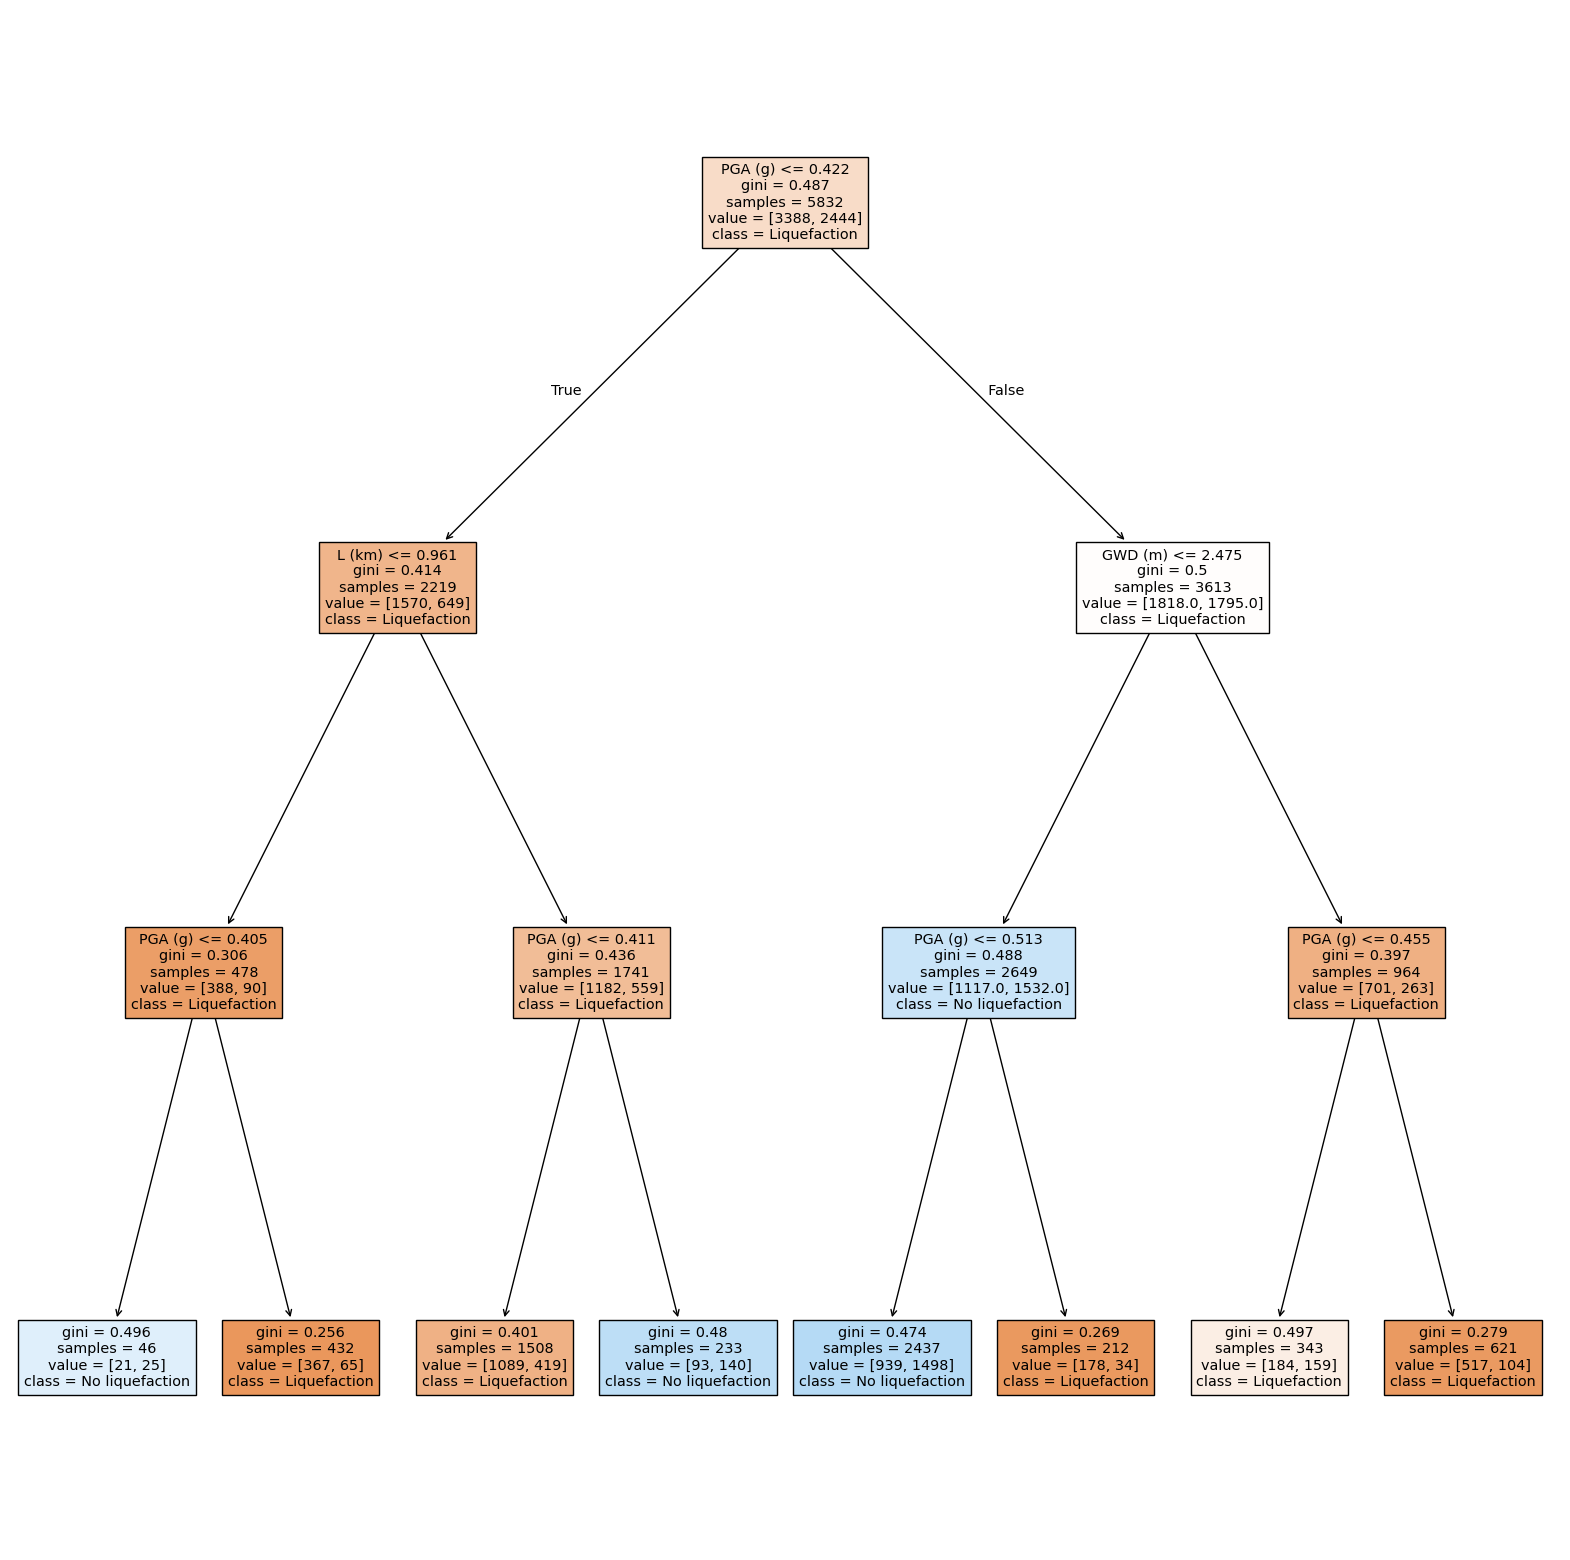

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(clf,
               feature_names=X_train.columns,
               class_names=['Liquefaction', 'No liquefaction'],
               filled = True)
fig.show()

### Update model

We increase the `max_depth` to 7 so we have a better fit.

> 💡 Try varying the `max_depth` from 5 - 9.

In [19]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [20]:
print('Training score: %.2f%%' %(clf.score(X_train, y_train) * 100))
print('Validation score: %.2f%%' %(clf.score(X_val, y_val) * 100))
print('Testing score: %.2f%%' %(clf.score(X_test, y_test) * 100))

Training score: 77.37%
Validation score: 73.97%
Testing score: 74.81%


## Metrics

A confusion matrix is commonly used to evaluate the performance of a machine learning classification model. It is an N x N matrix that summarizes how well the model classifies examples into N distinct classes.

The confusion matrix compares the actual target values to the predicted values. It shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) for each class. A higher count of TP and TN indicates better model performance, while more FP and FN points mean the model is making errors.

Key evaluation metrics derived from the confusion matrix are accuracy, recall (or true positive rate), and precision. Accuracy measures the overall percentage of correct classifications, treating false positives and false negatives equally.

Recall calculates the fraction of positive cases that are correctly classified as positive. It looks across the rows of the confusion matrix. Precision looks down the columns, measuring the fraction of positive predictions that are true positives. High precision means few false positives.

For binary classification, the formulas for these metrics are:

Accuracy = $(TP + TN)/(TP + TN + FP + FN)$

Recall = $TP/(TP + FN)$ = TP/(all positive data)

Precision = $TP/(TP + FP)$ = TP/(all positive predictions)

The confusion matrix and these metrics provide a quantitative assessment of model performance on a classification problem. They highlight the types of errors and allow targeted improvement.

**Precision**:
- Definition: Ratio of correctly predicted positive observations to the total predicted positives.
- Formula: 
  $$ \text{Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}} $$
- Interpretation: Of all instances labeled as positive, how many were actually positive?

**Recall (Sensitivity)**:
- Definition: Ratio of correctly predicted positive observations to all actual positives.
- Formula: 
  $$ \text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}} $$
- Interpretation: Of all actual positive instances, how many were correctly labeled?

**Trade-off**:
- Precision and recall often have a trade-off.
- F1 score combines both:
  $$ F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

**Decision Trees and Precision-Recall**:
- Decision trees use feature thresholds to make decisions.
- Adjusting decision thresholds can influence precision and recall.
- Precision-Recall curves visualize the trade-off.

> Note: Consider both precision and recall for imbalanced datasets or when false positives and negatives have different implications.


Researchers commonly use receiver operating characteristic (ROC) curves to evaluate the performance of machine learning classification models. A ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) for different classification probability thresholds. The TPR, also called recall, represents the percentage of positive cases correctly classified. The FPR represents the percentage of negative cases incorrectly classified as positive.

The FPR represents the fraction of the negative points that are incorrectly classified as positive (FPR = FP/(FP + TN) = FP/(all negative data)). An ideal classifier will have a ROC curve that passes through the top left corner, with a TPR of 1 and FPR of 0. A random classifier will have a ROC curve along the diagonal line where TPR equals FPR. Less accurate models have curves closer to the diagonal, while more accurate models have curves further up and left.

The area under the ROC curve (AUC) quantifies the model's performance. Larger AUC values indicate better classification, with a maximum of 1. AUC values near 0.5 imply performance equal to a random classifier.

Although designed for binary classification, ROC analysis can be extended to multi-class problems using a one-vs-rest approach. This involves creating a binary classifier for each class against the rest. The per-class ROC curves are averaged, weighting by class size, to produce an overall curve.

### Plot metrics

### Confusion Matrix

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, normalize=False):

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / len(y_true)
        cm = np.round(cm, decimals=3)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=plt.cm.Blues)

    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['No','Yes'])
    ax.set_yticklabels(['No','Yes'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    ax.set_title('Confusion Matrix')
    fig.tight_layout()
    plt.show()

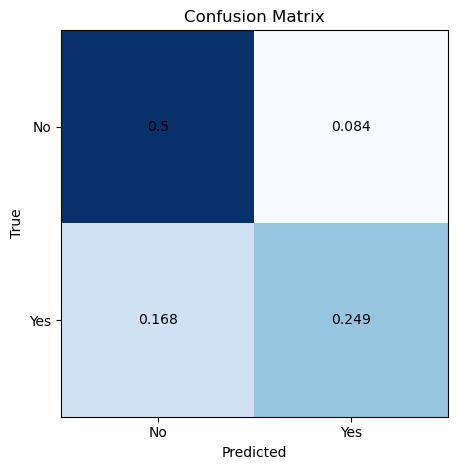

In [22]:
# make prediction on test set
y_pred = clf.predict(X_test)
# plot confusion matrix for test set
plot_confusion_matrix(y_test, y_pred, normalize=True)

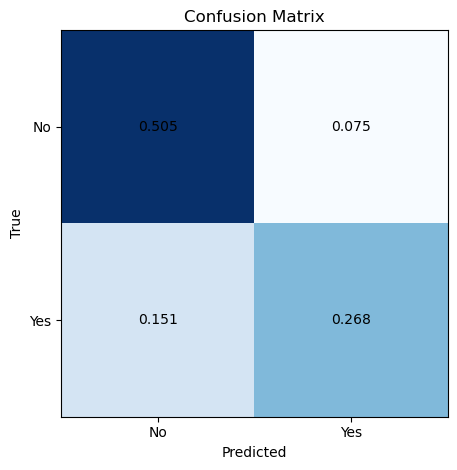

In [23]:
# make prediction on training set
y_pred_train = clf.predict(X_train)
# plot confusion matrix for training set
plot_confusion_matrix(y_train, y_pred_train, normalize = True)

### ROC

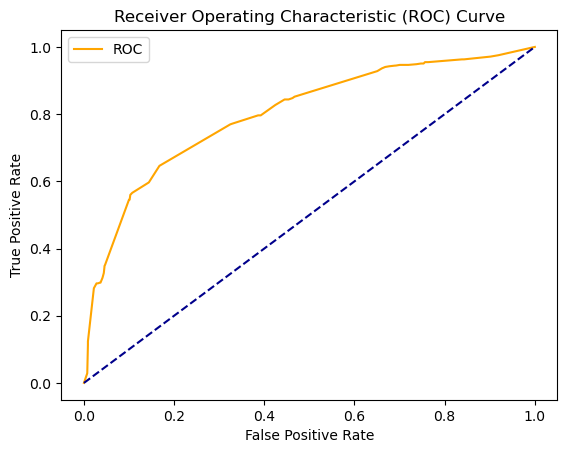

In [24]:
from sklearn.metrics import cohen_kappa_score, roc_curve, roc_auc_score, accuracy_score, classification_report, make_scorer

def plot_roc_cur(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

probs = clf.predict_proba(X_test)[:, 1]
fper, tper, thresholds = roc_curve(y_test, probs)
plot_roc_cur(fper, tper)

#### Precision recall curve

A precision-recall curve (PR curve) is another common technique used to evaluate the performance of classification models, alongside ROC curves. The PR curve plots precision vs. recall at different thresholds.

Precision measures the fraction of positive predictions that are true positives, while recall (same as true positive rate) measures the fraction of actual positives correctly predicted as positive.

A PR curve shows the tradeoff between precision and recall. High recall means detecting most of the positive cases, but potentially more false positives. High precision means positive predictions are more accurate, but some positives may be missed.

The curve is generated by varying the classification threshold and plotting precision and recall at each threshold. A perfect classifier will have a horizontal line at precision = 1. Random guessing produces a diagonal line.

The area under the PR curve (AUC) summarizes the overall performance. Higher AUC indicates better classification performance.

__Advantages of PR curves__:

 - Better visualization of performance for imbalanced classes. ROC curves can hide poor performance on the minority class.
 - Directly shows precision-recall tradeoff important for many applications.
 - Can be more useful than ROC curves when the positive class is more important.

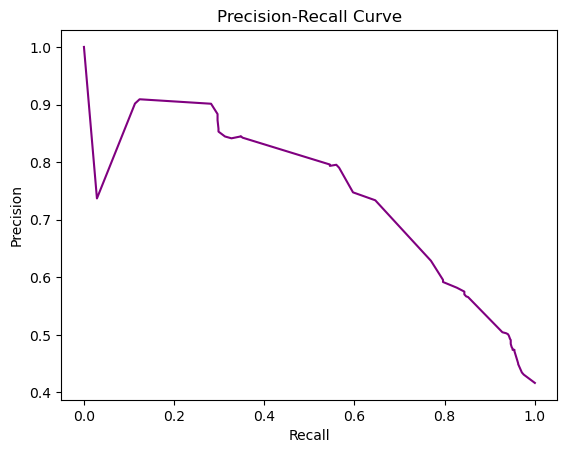

In [25]:
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

#use logistic regression model to make predictions
y_score = clf.predict_proba(X_test)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### Summary of decision trees


Pros and Cons
- Pros: Simple to understand and visualize, able to handle categorical and numerical data.
- Cons: Prone to overfitting, especially when the tree is deep, leading to poor generalization to unseen data. A small change in the data can lead to a very different tree.

# Random Forest

A random forest is an ensemble method that builds multiple decision trees and combines their predictions. Here's how it works:

**Bootstrapping**: For each tree in the forest, a subset of the training data is sampled with replacement. This helps in reducing overfitting by ensuring that each tree in the forest sees a slightly different subset of the data.

**Random Feature Selection**: When splitting a node, a random subset of features is considered. This further decorrelates the trees and improves generalization.

**Voting or Averaging**: For a classification problem, the mode of the classes predicted by individual trees is taken, and for regression, the mean prediction is used.

**Pros and Cons**

- Pros: Reduced risk of overfitting compared to a single decision tree, often gives better predictive performance, handles missing data well.
- Cons: More computationally expensive, harder to interpret because of the ensemble nature.

**Difference Between Random Forest and Decision Tree**

- Composition: A decision tree is a single tree, while a random forest is a collection of decision trees.
- Overfitting: Random forests are generally less prone to overfitting compared to individual decision trees.
- Prediction: A decision tree makes a prediction based on a single path through the tree, while a random forest averages or takes a vote from multiple trees.
- Computation and Interpretation: Random forests are more computationally intensive and less interpretable than individual decision trees.


In the context of SciML, both decision trees and random forests can be powerful tools. Decision trees are often used for their interpretability and simplicity, while random forests are employed for their robustness and improved predictive accuracy. Understanding the underlying mechanics and differences between these methods can help researchers and practitioners make informed choices for their specific applications.

![Decision tree vs Random Forest](decision-tree-rf.png)

### Automatic Hyperparameter tuning

Like we varied `max_depth`, there are other hyperparameters than can be tuned to improve performance.

[https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Cohen's kappa score measures the agreement between two raters/classifiers while taking into account the agreement expected by chance.

The $\kappa$ score is calculated as:

$$\kappa = (p_o - p_e) / (1 - p_e)$$

Where:

- $p_o$ is the observed agreement between raters (accuracy)
- $p_e$ is the expected agreement by chance

Values range from -1 to 1, where 0 is chance level agreement and 1 is perfect agreement.

In machine learning, kappa can be used as an evaluation metric for classification models. It gives a more robust measure of performance than simple accuracy, by accounting for random chance.

`GridSearchCV` is a tool in sklearn to perform hyperparameter tuning. It tries out all combinations of specified hyperparameters, fits a model on each, and returns the best performing configuration based on a scoring metric (like kappa).

So in this approach, we are using `GridSearchCV` to optimize the hyperparameters of a Random Forest Classifier to maximize the kappa score, rather than just overall accuracy.

The goal is to tune hyperparameters like `max_depth`, `n_estimators` etc. to find the values that result in the best kappa score, indicating the model's predictions have the strongest agreement with the true labels after accounting for chance.

This often results in a model that generalizes better than just optimizing for accuracy. The final model can then be evaluated with cross-validation to estimate real-world performance.

### K-Fold Cross-Validation (CV)

K-fold cross-validation is a popular resampling procedure used to evaluate a machine learning model's performance.

#### How K-Fold CV Works:
1. **Partitioning:** The original training data set is randomly partitioned into $ k $ equal-sized subsets or "folds."
2. **Training and Validation:** Of the $ k $ folds, $ (k-1) $ are used for training, and one is used for validation. This is repeated $ k $ times.
3. **Evaluation:** You'll train the model on $ (k-1) $ folds and validate it on the remaining fold, recording the error metric.
4. **Aggregation:** Average the recorded error metrics to obtain a single value that represents the model's performance.

#### Benefits of K-Fold CV
- **Bias-Variance Tradeoff:** Good bias-variance tradeoff.
- **Utilizing All Data:** Beneficial when dataset size is limited.
- **Reduction in Overfitting:** Helps in detecting overfitting.

#### Drawbacks
- **Computationally Expensive:** Requires training and validating the model $ k $ times.
- **Randomness in Partitions:** Performance estimate can be sensitive to how the data is divided.

In [26]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score, roc_curve, roc_auc_score, accuracy_score, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier

In [30]:
#define function to find best parameter combination based on Cohen’s kappa coefficient
def rfr_model(X, y):
# Perform Grid-Search
    kappa_scorer = make_scorer(cohen_kappa_score)
    gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'max_depth': range(2, 10),
            'n_estimators': [50, 100], # (5, 10, 50, 100, 1000),
            'max_features': ['sqrt'], # ('auto', 'sqrt', 'log2'),
            'criterion': ['entropy'], # ('gini','entropy'),
        },
        cv=10, verbose=0, n_jobs=-1,scoring=kappa_scorer)

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_

    rfr = RandomForestClassifier(max_depth=best_params["max_depth"],
                                 n_estimators=best_params["n_estimators"],
                                 max_features=best_params["max_features"], criterion = best_params["criterion"])
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10)
    predictions = cross_val_predict(rfr, X, y, cv=10)
    optimised_random_forest = gsc.best_estimator_

    print("Scores: {}", scores)
    return scores, optimised_random_forest

In [31]:
%%time
# run optimization algorithm and print CV scores
scores, rf = rfr_model(X_train, y_train)

Scores: {} [0.80821918 0.79280822 0.7787307  0.7787307  0.80102916 0.78730703
 0.80617496 0.7838765  0.7787307  0.79073756]
CPU times: user 5.21 s, sys: 145 ms, total: 5.35 s
Wall time: 8.48 s


In [33]:
#print GridSearch results
print('Best parameters:', rf)
print('---')
print('CV scores:', scores)
print('CV scores (average):', np.mean(scores))
print('Training score:', rf.score(X_train, y_train))
print('Testing score:', rf.score(X_test, y_test))

Best parameters: RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=50)
---
CV scores: [0.80821918 0.79280822 0.7787307  0.7787307  0.80102916 0.78730703
 0.80617496 0.7838765  0.7787307  0.79073756]
CV scores (average): 0.7906344721445522
Training score: 0.8473936899862826
Testing score: 0.794344473007712


# XGBoost (Extreme Gradient Boosting)

XGBoost is a popular and efficient gradient boosting framework that's widely used in machine learning, including in scientific contexts. It builds on the idea of boosting, where weak learners are combined to create a strong learner.

## Gradient Boosting Framework

Gradient Boosting is an ensemble learning method that fits a sequence of weak learners (such as shallow decision trees) on modified versions of the data.

The general form of the boosting model is:

$$ f(x) = \sum_{k=1}^K \alpha_k h_k(x) $$

Where:
- $f(x)$ is the prediction for input $ x $
- $ \alpha_k $ is the weight of the $ k $-th weak learner
- $ h_k(x) $ is the prediction of the $ k $-th weak learner
- $ K $ is the total number of weak learners

## Algorithm

1. **Initialization:** Start with a constant prediction $ f_0(x) $
2. **Iteratively Add Trees:** For $ k = 1 $ to $ K $:
   a. Compute the negative gradient (or "pseudo-residuals") of the loss function:
    $$ r_i = -\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)} $$  
   b. Fit a weak learner to predict the pseudo-residuals.  
   c. Compute the weight $ \alpha_k $ that minimizes the loss.  
   d. Update the model by adding the weighted weak learner:
      $$ f_k(x) = f_{k-1}(x) + \alpha_k h_k(x) $$

## XGBoost Enhancements

XGBoost adds several enhancements to the basic gradient boosting framework:

### Regularization

XGBoost includes L1 (Lasso) and L2 (Ridge) regularization terms in the loss function to prevent overfitting:

$$ \text{Loss} = L(y, f(x)) + \lambda_1 \sum |\alpha_k| + \lambda_2 \sum \alpha_k^2 $$

### Handling Missing Data

XGBoost can automatically learn the best direction to handle missing values during training, allowing it to handle datasets with missing data.

### Column Block and Parallelization

XGBoost employs a column block structure that allows parallelization over both instances and features, leading to efficient computation.

### Hyperparameters

- **learning_rate:** Step size shrinkage to prevent overfitting.
- **max_depth:** Maximum depth of the decision trees.
- **n_estimators:** Number of boosting rounds.
- **subsample:** Fraction of the data to be used for each boosting round, enabling stochastic gradient boosting.

![XGB](xgb.png)

In [42]:
import xgboost
xgb = xgboost.XGBClassifier(max_depth=9)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [43]:
print('Training score: %.2f%%' %(xgb.score(X_train, y_train) * 100))
print('Validation score: %.2f%%' %(xgb.score(X_val, y_val) * 100))
print('Testing score: %.2f%%' %(xgb.score(X_test, y_test) * 100))

Training score: 99.76%
Validation score: 86.64%
Testing score: 84.75%


## Explainable AI

### Feature Importance Metrics

Feature importance metrics provide insights into the contribution of individual features (or variables) to a predictive model. Understanding the importance of different features can help in feature selection, model interpretation, and understanding the underlying relationships within the data.

#### Types of Importance Metrics

##### 1. **Weight-Based Importance**

In models like linear regression or logistic regression, the magnitude of the coefficients can indicate the importance of features. For tree-based models like Random Forest, the importance of a feature can be calculated based on the average gain of the feature when it is used in trees.

##### 2. **Permutation Importance**

Permutation importance is a method that can be applied to any model. It is computed as follows:

a. **Calculate a Performance Metric:** Train the model and calculate a performance metric (such as accuracy or MSE) using a validation set.  
b. **Permute the Feature Values:** Shuffle the values of the feature of interest across the validation set, destroying the relationship between the feature and the target.  
c. **Recompute the Performance Metric:** Use the permuted data to compute the performance metric again.  
d. **Calculate Importance:** The difference between the original metric and the permuted metric provides a measure of importance.

In [36]:
## Compute feature importance for random forest
def plot_feature_importance(X, model):
    df2=pd.get_dummies(X)
    features = df2.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]  # top 10 features
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

    fi = pd.DataFrame({'feature': list(X.columns),
                       'importance': model.feature_importances_}).\
                       sort_values('importance', ascending = False)

    return fi

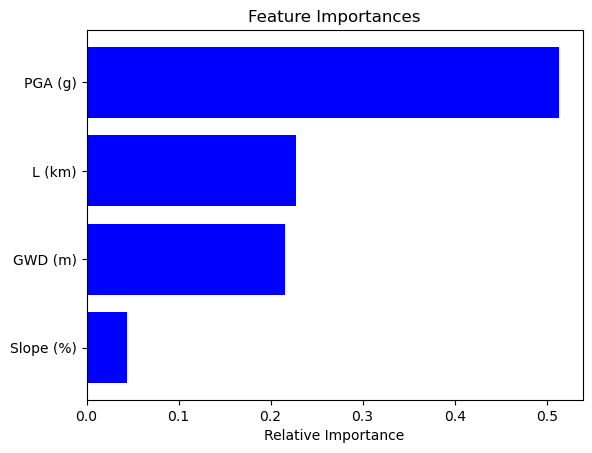

,feature,importance
3,PGA (g),0.513312
1,L (km),0.227284
0,GWD (m),0.215878
2,Slope (%),0.043525


In [37]:
# Display results for decision tree
plot_feature_importance(X_test, clf)

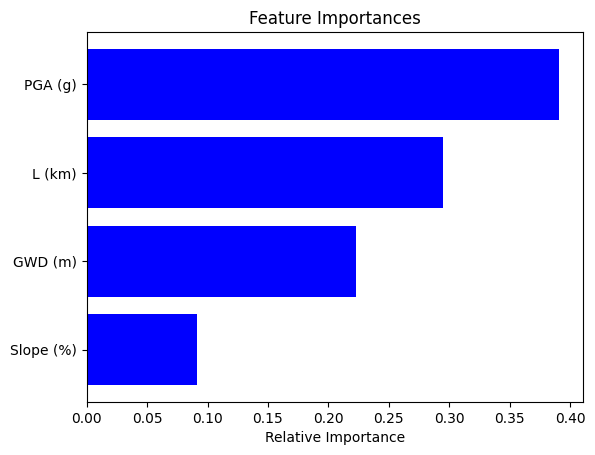

,feature,importance
3,PGA (g),0.390678
1,L (km),0.294591
0,GWD (m),0.223014
2,Slope (%),0.091718


In [42]:
# Display results for random forest
plot_feature_importance(X_test, rf)

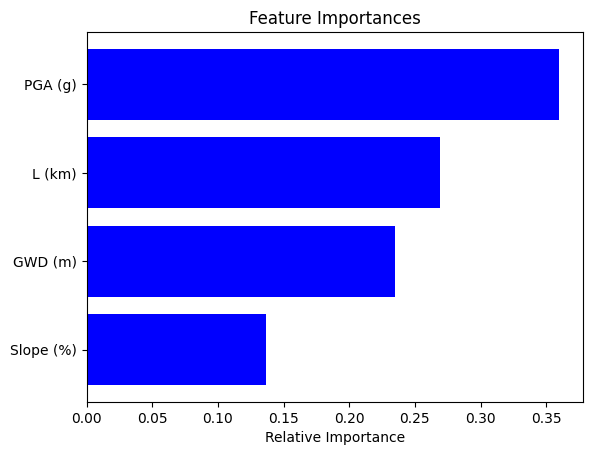

,feature,importance
3,PGA (g),0.359728
1,L (km),0.269205
0,GWD (m),0.234558
2,Slope (%),0.136509


In [43]:
# Display results for XGB
plot_feature_importance(X_test, xgb)

### 3. Shapley Values


SHAP values are based on cooperative game theory and provide a unified measure of feature importance. They give the average contribution of a feature value to every possible prediction.

For a model with $M$ features, the Shapley value for feature $ i $ is computed as:

$$ \phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(M - |S| - 1)!}{M!} [v(S \cup \{i\}) - v(S)] $$

Where:
- $ S $ is a subset of features excluding feature $ i $
- $ N $ is the set of all features
- $ v(S) $ is the value function that gives the prediction for subset $ S $


### Understanding SHAP Values: An Analogy

SHAP values help us understand how different features (or variables) contribute to a prediction in a machine learning model. To explain this without mathematics, let's use an analogy of three team members working together on a project. Imagine that the team members are Alice, Bob, and Charlie, and we want to know how much each one contributed to the project's success.

#### The Project

The project's success is measured by the total output, and we want to fairly distribute the credit for this success among Alice, Bob, and Charlie.

#### Shapley Value Concept

Imagine breaking down the project into smaller tasks and observing how much the output changes when each team member is added or removed. The goal is to find the average contribution of each member over all possible ways the team could have been formed.

##### Step by Step Explanation

1. **No Team Members:** First, we measure the output with no team members working (a baseline).
2. **Adding One Member:** Then, we add each team member one by one and measure how much the output changes.
   - With Alice alone
   - With Bob alone
   - With Charlie alone
3. **Adding Two Members:** Next, we measure the change in output with pairs of team members:
   - Alice and Bob
   - Alice and Charlie
   - Bob and Charlie
4. **All Three Members:** Finally, we measure the output with all three working together.

#### Calculating Contributions

By comparing all these different combinations, we can calculate the average contribution of each team member. The SHAP value for each person is their fair share of the contribution to the project's success.

- **Alice's SHAP Value:** The average change in output when Alice is part of the team.
- **Bob's SHAP Value:** The average change in output when Bob is part of the team.
- **Charlie's SHAP Value:** The average change in output when Charlie is part of the team.

![Shapley](shap.png)

In [44]:
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer(X_test)

In [45]:
X_test_target.head()

,GWD (m),L (km),Slope (%),PGA (g),Target
2788,2.028173,0.821665,1.503365,0.454330,1
1021,2.814171,0.901499,1.182408,0.490202,0
5389,2.954235,0.640724,0.168798,0.419889,0
640,3.135862,1.804868,3.405960,0.506093,0
5593,2.981111,0.402975,0.792859,0.423812,1


SHAP values are a measure used to explain the output of machine learning models. They tell us how much each feature in the model contributes to a particular prediction, compared to a baseline prediction.

#### Positive vs. Negative SHAP Values

- **Positive SHAP Values:** When a feature has a positive SHAP value, it means that the presence (or value) of that feature pushes the model's output higher than the baseline.
  - **Example:** In our lateral spreading prediction the PGA (a feature) gives a positive SHAP value, it means that higher PGA are generally associated with higher chance of lateral spreading.

- **Negative SHAP Values:** Conversely, when a feature has a negative SHAP value, it means that the presence (or value) of that feature pushes the model's output lower than the baseline.
  - **Example:** Still considering lateral spreading, if water table being too low (a feature) gives a negative SHAP value, it suggests that such sites are generally predicted to have less chance of lateral spreading.


The term $E(f(x))$ represents the expected value or average prediction of the model over the entire dataset. Think of it as the "baseline prediction." When you see $E(f(x))$ , it's referring to what the model would predict on average, without considering any specific feature values.

- **Example:** In the context of predicting house prices, $E(f(x))$  might be the average chance of lateral spreading the model predicts when it doesn't consider any specific features of the sites. It's the starting point before we account for unique factors like having GWT or a high PGA.

#### Positive prediction
In this example, we show a site that is predicted to have positive lateral spreading (failure). Here, the high slope anlge (0.835%) has the most influence in the positive prediction of lateral spreading, followed by a shallow ground water depth of 1.8 m and its close proximity to the river (L = 0.74 km).

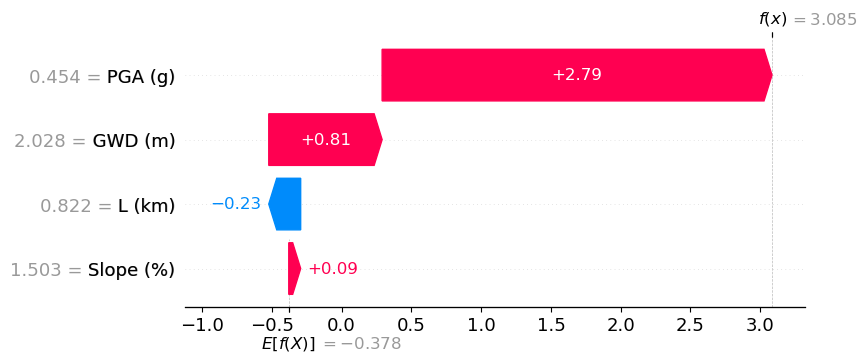

In [48]:
shap.plots.waterfall(shap_values[0])

#### Negative prediction

In this example, we show XGB predicting a site that has no chance of lateral spreading. The distance to the river (L ~ 2 km) seems to be the primary reason.

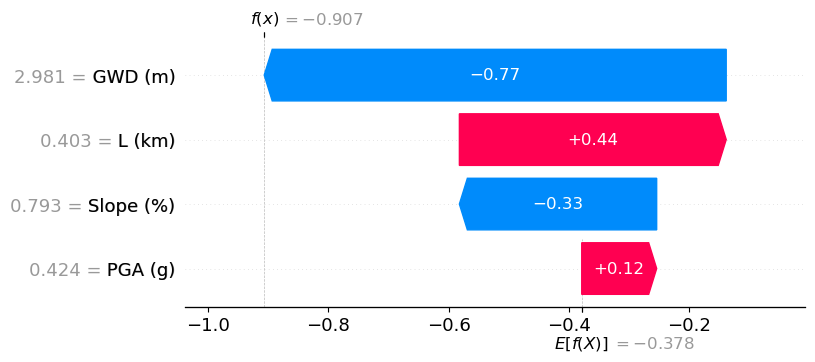

In [47]:
shap.plots.waterfall(shap_values[4])

### Global explanation

We also observe global SHAP values and see how different features influence the results. High feature values are shown in red and Low feature values are shown in blue. For e.g., shorter distance to the river (blue points for $L$) are associated with high chance of lateral spreading. Similarly, deeper ground water depth (red GWD) means lower chances of lateral spreading.

However, we do see that high PGA, shows less chance of lateral spreading, contradictory to the engineering understanding that high acceleration will cause more displacements and failures.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


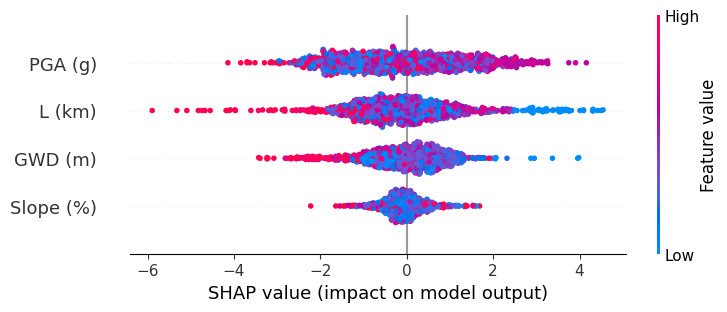

In [48]:
shap.plots.beeswarm(shap_values)